<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/notebooks/GalFit_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**


In [1]:
!pip install astroquery --quiet
!pip install sep --quiet
!pip install photutils --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sb
from astroquery.sdss import SDSS
from astroquery.skyview import SkyView
from astroquery.simbad import Simbad
from astroquery.ned import Ned

from astropy import coordinates as coords
import astropy.units as u
from astropy.io import fits
from matplotlib import colors as col
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.table import Table
from photutils.aperture import aperture_photometry
import copy

import sys
import requests

if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

import photutils as phot
from photutils import aperture as aper
from photutils.segmentation import deblend_sources
import sep

# To plot pretty figures
%matplotlib inline
#%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (15,8)

/tmp/ipython-input-2-3081563721.py:8: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.
  from astroquery.ned import Ned


In [3]:
os.system('wget https://users.obs.carnegiescience.edu/peng/work/galfit/galfit3-debian64.tar.gz')
os.system('tar -xvf galfit3-debian64.tar.gz')
os.system('rm galfit3-debian64.tar.gz')

0

In [8]:
!sudo apt-get install libncurses5

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libtinfo5
The following NEW packages will be installed:
  libncurses5 libtinfo5
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 207 kB of archives.
After this operation, 883 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libtinfo5 amd64 6.3-2ubuntu0.1 [100 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libncurses5 amd64 6.3-2ubuntu0.1 [107 kB]
Fetched 207 kB in 0s (778 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling 

In [9]:
!./galfit


GALFIT Version 3.0.5 -- Apr. 23, 2013

Enter template file name: ^C


In [ ]:
os.system('wget https://data.sdss.org/sas/dr17/env/MANGA_PHOTO/pymorph/1.1.1/manga-pymorph-DR17.fits')

0

## **SDSS PSF Extract and  Image Preparation**

In [ ]:
def reconstructPSF(psFieldFilename, filter, row, col, trim = True,download_fits = True):

  filterIdx = 'ugriz'.index(filter) + 1
  psField = fits.open(psFieldFilename)
  pStruct = psField[filterIdx].data
  header  = psField[filterIdx].header

  nrow_b = pStruct['nrow_b'][0]
  ncol_b = pStruct['ncol_b'][0]

  rnrow = pStruct['rnrow'][0]
  rncol = pStruct['rncol'][0]

  nb = nrow_b * ncol_b
  coeffs = np.zeros(nb.size, float)
  ecoeff = np.zeros(3, float)
  cmat = pStruct['c']

  rcs = 0.001
  for ii in range(0, nb.size):
      coeffs[ii] = (row * rcs)**(ii % nrow_b) * (col * rcs)**(ii / nrow_b)

  for jj in range(0, 3):
      for ii in range(0, nb.size):
          ecoeff[jj] = ecoeff[jj] + cmat[int(ii / nrow_b), ii % nrow_b, jj] * coeffs[ii]

  psf = pStruct['rrows'][0] * ecoeff[0] + \
      pStruct['rrows'][1] * ecoeff[1] + \
      pStruct['rrows'][2] * ecoeff[2]

  psf = np.reshape(psf, (rnrow, rncol))
  if trim:
    psf = psf[10:40, 10:40]  # Trim non-zero regions.
  if download_fits:
    hdu = fits.PrimaryHDU(data = psf, header = header )
    hdul = fits.HDUList(hdu)
    hdul.writeto(f'psf_{filter}.fits',overwrite = True)

  return psf

## **GalFit Wrap**

In [ ]:
def init(source=None,pos = None,ra= None, dec = None):
  # Resolving source

  query = Simbad.query_object(source)
  print('SIMBAD\n',query)
  if query is None or len(query)<1:
    query   = Ned.query_object(source)
    print('NED\n',query)
  if query is not None and len(query)>0:
    ra  = query[0]['RA']
    dec = query[0]['DEC']

    pos = coords.SkyCoord(f'{ra} {dec}', unit=(u.hourangle, u.deg),frame='icrs')
    xid = SDSS.query_region(pos)
    if xid is not None:
      row = xid[0]
      run    = row['run']
      camcol = row['camcol']
      field  = row['field']
      rerun  = row['rerun']

      print("Downloading Images")
      galimg_g, mask_g = image_gen(xid=xid,pos=pos,band = 'g')
      galimg_r, mask_r = image_gen(xid=xid,pos=pos,band = 'r')
      galimg_i, mask_i = image_gen(xid=xid,pos=pos,band = 'i')
  else:
      xid = None
      print(source)

  if xid is None:
    print(ra, dec)
    print("Downloading Images")
    url = f"https://skyserver.sdss.org/dr17/SkyServerWS/SDSSFields/FieldArray?ra={ra}&dec={dec}&radius=5&format=csv"
    response = requests.get(url)
    df = pd.read_csv(bytesio(response.content), skiprows = 1)
    params = df.head(1)
    row    = df.head(1)
    run    = row['run'].values[0]
    camcol = row['camcol'].values[0]
    field  = row['field'].values[0]
    rerun  = row['rerun'].values[0]

    pos = coords.SkyCoord(f'{ra} {dec}', unit=(u.deg, u.deg),frame='icrs')
    galimg_g, mask_g = image_gen(pos= pos, params = params,band = 'g')
    galimg_r, mask_r = image_gen(pos= pos, params = params,band = 'r')
    galimg_i, mask_i = image_gen(pos= pos, params = params,band = 'i')

  # Run in SDSS SAS
  if ra is not None:
    galimg = np.concatenate((galimg_g,galimg_r,galimg_i), axis =0)
    mask   = np.concatenate((mask_g,mask_r,mask_i), axis =0)

    filename = f"psField-00{run}-{camcol}-00{field}.fit"

    if len(str(field)) ==3:
      filename = f"psField-00{run}-{camcol}-0{field}.fit"

    # Download psField file
    if not os.path.exists(filename):
      url = f"https://data.sdss.org/sas/dr17/eboss/photo/redux/{rerun}/{run}/objcs/{camcol}/{filename}"
      print(url)
      status = os.system(f'!wget {url}')
      os.system(f'wget {url}')


    # Reconstruct PSF
    psf_g   = reconstructPSF(filename,'g',1000,1000)
    psf_r   = reconstructPSF(filename,'r',1000,1000)
    psf_i   = reconstructPSF(filename,'i',1000,1000)

    psf = np.concatenate((psf_g,psf_r,psf_i), axis =0)
    models = model_init(source, galimg_g.shape,pscale = 0.396, bands = ['g','r','i'])

    return galimg, mask, psf, models

def image_gen(xid= None, pos=None, params = None,band = 'g') :

  count = 0
  while True:
    try:
      hdul = SDSS.get_images(matches = xid, band = band)[0]
      break
    except:
      count+=1
    if count>5:
      break

  if xid is None and params is not None:
    url = params[f'{band}_url'].values[0]
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
      os.system(f'wget {url}')

    hdul = fits.open(filename)

  hdu  = hdul[0]
  wcs  = WCS(hdu.header)

  cutout = Cutout2D(hdu.data,pos,size = [128,128], wcs = wcs)
  cutout.wcs.wcs.crpix = [63, 63]
  header_new = cutout.wcs.to_header()

  hdu.data = cutout.data/hdu.header['NMGY']  +1000        # Counts
  hdu.header.update(header_new)
  hdu.header['GAIN']     = 3.0
  hdu.header['EXPTIME']  = 1.0
  hdu.header['RDNOISE '] = 4.5
  hdu.header['NCOMBINE'] = 1.0
  hdu.header['ZPT']      = 22.5 - 2.5*np.log10(hdu.header['NMGY'])
  hdu.header['BUNIT']    = "ADU"

  hdu.writeto(f'gal_{band}.fits',overwrite = True)

  mask = generate_mask(hdu)
  hdu_m = fits.PrimaryHDU(data = mask)
  hdul = fits.HDUList(hdu_m)
  hdul.writeto(f'mask_{band}.fits',overwrite = True)
  return hdu.data, hdu_m.data

def model_init(source, shape, pscale, bands = ['g','r','i'] ):
  plateifu = source[6:]
  cats = [ Table.read('/content/manga-pymorph-DR17.fits',hdu = i )for i in range(1,4)]
  models = {}
  for band in bands :
    cat = cats[bands.index(band)]
    row = cat[cat['PLATEIFU']==plateifu]
    if len(row)==0:
      mangaid = source[6:]
      row     = cat[cat['MANGA_ID']==mangaid]
    if len(row)!=0:
      models[f'models_{band}'] = []
      model = {}

      model[0] = 'sersic'                               #  object type
      model[1] = f'{shape[0]//2} {shape[0]//2} 1 1'     #  position x, y
      model[3] = f"{row['M_SE_BULGE'].value[0]} 1"      #  Integrated magnitude
      model[4] = f"{row['A_HL_SE_BULGE'].value[0]/pscale} 1"   #  R_e (half-light radius)[pix]
      model[5] = f"{row['N_SE_BULGE'].value[0]} 1"      #  Sersic index n (de Vaucouleurs n=4)
      model[9] = f"{row['BA_SE_BULGE'].value[0]} 1"     #  axis ratio (b/a)
      model[10]= f"{row['PA_SE_BULGE'].value[0]} 1"     #  position angle (PA) [deg: Up=0, Left=90]
      model['Z'] = 0                                    #  output option (0 = resid., 1 = Don't subtract

      models[f'models_{band}'].append(model)
      model = copy.deepcopy(model)

      model[3] = f"{row['M_SE_BULGE'].value[0]} 1"
      model[4] = f"{row['A_HL_SE_BULGE'].value[0]/(pscale)*2} 1"
      model[5] = f"{0.5} 1"
      model[9] = f"{0.3} 1"

      models[f'models_{band}'].append(model)
      model = copy.deepcopy(model)

      model[0] = 'expdisk'
      model[1] = f"{shape[0]//2} {shape[0]//2} 1 1"
      model[3] = f"{row['M_SE_DISK'].value[0]} 1"
      model[4] = f"{row['A_HL_SE_DISK'].value[0]/(pscale)} 1"
      del model[5]
      model[9] = f"{row['BA_SE_DISK'].value[0]} 1"
      model[10]= f"{row['PA_SE_DISK'].value[0]} 1"
      model['Z'] = 0
      models[f'models_{band}'].append(model)

      model = {}
      model[0]= 'sky'
      model[1]= '1000 1'
      model['Z'] = 0

      models[f'models_{band}'].append(model)
    else:
          models={'models_g': [{0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '17.8 1',
                4: '13.2376 1',
                5: '0.3199 1',
                9: '0.3738 1',
                'Z': 0},
                {0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '18.8 1',
                4: '6 1',
                5: '1.3634 1',
                9: '0.4 1',
                'Z': 0},
                {0: 'expdisk',
                1: '64 64 1 1',
                10: '-65  1',
                3: '19.5 1',
                4: '100 1',
                9: '0.3 1',
                'Z': 0},
                {0: 'sky', 1: '1000 1', 'Z': 0}],
              'models_r': [{0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '19.0243 1',
                4: '13.2376 1',
                5: '0.3199 1',
                9: '0.3738 1',
                'Z': 0},
                {0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '18.9396 1',
                4: '6 1',
                5: '1.3634 1',
                9: '0.4 1',
                'Z': 0},
                {0: 'expdisk',
                1: '64 64 1 1',
                10: '-73.3458  1',
                3: '18 1',
                4: '40 1',
                9: '0.3 1',
                'Z': 0},
                {0: 'sky', 1: '1000 1', 'Z': 0}],
              'models_i': [{0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '17.0243 1',
                4: '13.2376 1',
                5: '0.3199 1',
                9: '0.3738 1',
                'Z': 0},
                {0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '17.9396 1',
                4: '6 1',
                5: '1.3634 1',
                9: '0.4 1',
                'Z': 0},
                {0: 'expdisk',
                1: '64 64 1 1',
                10: '-73.3458  1',
                3: '16 1',
                4: '40 1',
                9: '0.3 1',
                'Z': 0},
                {0: 'sky', 1: '1000 1', 'Z': 0}]}

  return models


def generate_mask(hdu):

  wcs = WCS(hdu.header)
  data = hdu.data
  #data = data.byteswap().newbyteorder()
  bkg = sep.Background(data,bh=64,bw=64,fh=3,fw=3)
  bkg_image = bkg.back()
  bkg_rms = bkg.rms()

  sigma = 3.0 * 0.42466090014400953  # FWHM = 3.

  kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
  kernel.normalize()

  threshold = bkg.back() + (3.0 * bkg.rms())

  segm = phot.detect_sources(data, threshold, npixels=5, kernel=kernel)
  segm_deblend = deblend_sources(data, segm, npixels=5,
                               nlevels=32, contrast=0.001)
  segm_deblend = segm
  if len(segm_deblend.areas)>1:
    ind = np.where(segm_deblend.areas!=segm_deblend.areas.max())[0]+1
    segm_deblend.keep_labels(ind)
    mask = np.where(segm_deblend.data>0,1,0)
  else:
    mask = data*0
  return mask

def show_image(oimgs, modss, bands=['g','r','i']):
  fig, ax = plt.subplots(3,6, figsize = (35,20))
  colors = ['red','green','black']
  models = ['sersic','sersic','expdisk']
  for j, band in enumerate(bands):

    mask = fits.open(f'mask_{band}.fits')[0].data
    data_s = oimgs[j][1].data
    masked_data = np.ma.masked_array(data = data_s, mask = mask)
    ax[j][0].imshow(np.fliplr(data_s.T),cmap = 'jet',origin = 'lower')
    mods = modss[j]

    for i in range(1,4):
      data = oimgs[j][i].data
      masked_data = np.ma.masked_array(data = data, mask = mask)

      ax[j][i].imshow(np.fliplr(masked_data.T), cmap = 'jet',origin = 'lower')

    ax[j][4].imshow(np.fliplr(data_s.T), cmap = 'jet',origin = 'lower')

    apertures = aperture_gen(mods[:-1])
    for k, aperture in enumerate(apertures):
      apertures[aperture].plot(ax[j][4],color = colors[k], label = models[k])

    ax[j][4].legend()
    ax[j][5].hist(masked_data.ravel())
    ax[j][5].grid(False)
    ax[j][5].set_yscale('log')

    ax[j][0].set_title(f'Source | {band} band')
    ax[j][1].set_title(f'Masked Source | {band} band')
    ax[j][2].set_title(f'Masked Model | {band} band')
    ax[j][3].set_title(f'Masked Residual | {band} band')
    ax[j][4].set_title(f'Apertures on Source | {band} band')
    ax[j][5].set_title(f'Masked Residual Hist | {band} band')
  fig.suptitle('GalFit', y = 0.91,fontsize = 20)
  plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
  plt.show();

def aperture_gen(models):
  apertures = {}
  for i,model in enumerate(models):

    X_c = model[f'{i+1}_XC'].split('+')[0]
    if '*' in X_c:
      print('Error in X_c')
      X_c = float(X_c[1:-2])
    else:
      X_c = float(X_c)

    Y_c = model[f'{i+1}_YC'].split('+')[0]
    if '*' in Y_c:
      print('Error in Y_c')
      Y_c = float(Y_c[1:-2])
    else:
      Y_c = float(Y_c)

    PA = model[f'{i+1}_PA'].split('+')[0]
    if '*' in PA:
      print('Error in PA')
      PA = float(PA[1:-2])
    else:
      PA = float(PA)

    AR = model[f'{i+1}_AR'].split('+')[0]
    if '*' in AR:
      print('Error in AR')
      AR = float(AR[1:-2])
    else:
      AR = float(AR)


    if i<2:
      RE = model[f'{i+1}_RE'].split('+')[0]
      if '*' in RE:
        print('Error in X_c')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    else:
      RE = model[f'{i+1}_RS'].split('+')[0]
      if '*' in RE:
        print('Error in RS')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    a = RE
    b = AR*a
    aperture = aper.EllipticalAperture((Y_c-1,X_c-1), a,b,theta = (PA)*np.pi/180)
    apertures[f'aper_{i+1}'] = aperture
  return apertures


In [ ]:
from subprocess import Popen, PIPE
from scipy.signal import fftconvolve

def CreateFile(Iimg, region, models, sky='Default', fout=None, **kwargs):
    '''
        Creates a file to be run with galfit
        options can be given through kwargs
        models is a list of dicts where the keys are the model parameters.
        Note that region includes the initial pixel, ie, a box from 200 to 300 will have 101 pixels, in python this will be a[199:300]
        Example sersic model:
        {
         0  : 'sersic',      #  object type
         1  : '250 490 1 1', #  position x, y
         3  : '12. 1',       #  Integrated magnitude
         4  : '9 1',         #  R_e (half-light radius)   [pix]
         5  : '1.5 1',       #  Sersic index n (de Vaucouleurs n=4)
        'c0': '0 1',         #  Boxyness
         9  : '1 1',         #  axis ratio (b/a)
        10  : '0 1',         #  position angle (PA) [deg: Up=0, Left=90]
        'Z' :  0}            #  output option (0 = resid., 1 = Don't subtract)
        PLEASE be aware that if filenames are too long galfit will dump core! (psffile specifically!)
    '''
    if len(models) == 0:
        print('Need at least one model!')
        return 1
    defdict = {
        'Iimg': Iimg,  # Input data image (FITS file)
        'Oimg': 'out.fits',  # Output data image block
        'Simg': '',  # Sigma Image
        'Pimg': 'none',  # PSF Image
        'PSFf': '1',  # PSF fine sampling factor
        'badmask': 'none',  # Bad pixel mask (FITS image or ASCII coord list)'
        'constr': 'none',  # File with parameter constraints (ASCII file) '
        'region': '{0} {1} {2} {3}'.format(region[0], region[1], region[2], region[3]), # Image region to fit (xmin xmax ymin ymax)'
        'convbox': '100 100',  # Size of the convolution box (x y)'
        'ZP': '0',  # Magnitude photometric zeropoint '
        'scale': '0.03 0.03',  # Plate scale (dx dy)    [arcsec per pixel]'
        'dispt': 'regular',  # Display type (regular, curses, both)'
        'opt': '0',  # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'
    }
    defdict.update(kwargs)

    fout = open(fout, 'w')
    fout.write('A) {0} \n'.format(defdict['Iimg']))
    fout.write('B) {0} \n'.format(defdict['Oimg']))
    fout.write('C) {0} \n'.format(defdict['Simg']))
    fout.write('D) {0} \n'.format(defdict['Pimg']))
    fout.write('E) {0} \n'.format(defdict['PSFf']))
    fout.write('F) {0} \n'.format(defdict['badmask']))
    fout.write('G) {0} \n'.format(defdict['constr']))
    fout.write('H) {0} \n'.format(defdict['region']))
    fout.write('I) {0} \n'.format(defdict['convbox']))
    fout.write('J) {0} \n'.format(defdict['ZP']))
    fout.write('K) {0} \n'.format(defdict['scale']))
    fout.write('O) {0} \n'.format(defdict['dispt']))
    fout.write('P) {0} \n'.format(defdict['opt']))

    emodels = list(models)
    if 'sky' not in [a[0] for a in emodels]:
        if sky=='Default':
            sky = {0: 'sky', 1: '1 1', 2: '0 0',
                   3: '0 0', 'Z': 0, 'Comment': 'StandardSky'}
        if sky!='None':
            emodels.append(sky)
    for model in emodels:
        for i in np.argsort(list(model.keys())):
            key = list(model.keys())[i]
            s='{0}) {1} \n'.format(key, model[key])
            if key in ['Comment','mskidx','origin']:s='#'+s
            fout.write(s)
    fout.close()
    return 0

def rungalfit(infile, outfile='out.fits', timeout=600, verb=True):
    # galfit needs to be in the path
    # will run here, so file either needs to be complete path, or here...
    Popen(["rm", outfile], stderr=PIPE)
    p     = Popen(["timeout", str(timeout), "./galfit", infile], stdout=PIPE)
    ES    = p.wait()
    pout  = p.stdout.readlines()
    if ES == 124:
        if verb:
            for l in pout:
                print( l[:-1])
        if verb:
            print('Process timeout...')
        return pout, [-1, -1, -1, -1], [], 124
    try:
        outfit = fits.open(outfile)
        if len(outfit)==1:
            imgi = 0
            if verb: print('Only the model was found, no fitting perfomed')
        else: imgi=2
        models = []
        for mod in [x for x in outfit[imgi].header if 'COMP' in x]:
            models.append({mod: outfit[imgi].header[mod]})
            for key in [x for x in outfit[imgi].header if mod[5:]+'_' in x]:
                if verb:
                    print(key, outfit[imgi].header[key])
                models[-1][key] = outfit[imgi].header[key]
        return pout, outfit, models, 0
    except Exception as E:
        if verb:
            for l in pout:
                print( l[:-1])
        if verb:
            print(E)
        if verb:
            print('something went wrong...')
        return pout, [-1, -1, -1, -1], [], 1

def maskfiles(sci, msk, wht=None, fout=["tsci.fits", "twht.fits"], verb=True):
    overify='fix' if verb else 'silentfix'
    Popen(["rm", fout[0]], stderr=PIPE)
    scifits = fits.open(sci)
    scifits[0].data *= msk
    scifits.writeto(fout[0], clobber=True,output_verify=overify)
    scifits.close()
    if wht is not None:
        Popen(["rm", fout[1]], stderr=PIPE)
        whtfits = fits.open(wht)
        whtfits[0].data *= msk
    else:
        wht=np.zeros(msk.shape)
        wht[msk!=1]=1
        whtfits = fits.HDUList([fits.PrimaryHDU(wht)])
    whtfits.writeto(fout[1], clobber=True,output_verify=overify)
    whtfits.close()
    return fout

In [ ]:
def isit(A):
    #Return True if A is iterable
    try:
        iter(A)
    except:
        return False
    return True

def middlebin(A):
    #Return the middle bin of an array
    return (A[1:]+A[:-1])*0.5

def getWP(D,w,p=None):
    from scipy.interpolate import interp1d
    #Gets percentile p for array D with weights w
    #if p is none, interpolator is return
    #p is given in percentage
    #Normalize
    w=np.array(w)
    w/=np.sum(w)/100
    #Sort ascending
    idxs=np.argsort(D)
    w=w[idxs]
    #Cumulative to find percentile
    C=np.cumsum(w)
    C=middlebin(np.append([0.],C))
    C[0]=0.
    C[-1]=100.

    # C=np.cumsum(w[1:])
    # C=np.append([0],C)

    # Interpolator between Cumulative Sum and value of A
    it=interp1d(C,np.array(D)[idxs])
    if p is None:
        return it
    else:
        return it(p)

def getContours(H,l,E=None):
    """
        Assumes H is well shown with plt.imshow(H,origin="lower",extent=E)
    """
    # H=np.flipud(H)
    # from matplotlib import _cntr as cntr
    from skimage import measure
    if E is None:
        E=[0,H.shape[1],0,H.shape[0]]
    locx=middlebin(np.linspace(E[0],E[1],H.shape[1]+1,endpoint=True))
    locy=middlebin(np.linspace(E[2],E[3],H.shape[0]+1,endpoint=True))
    y, x = np.mgrid[:H.shape[0], :H.shape[1]]

    contours = measure.find_contours(H, l)

    # c = cntr.Cntr(x, y, H)
    # res = c.trace(l)
    # nseg = len(res) // 2
    # segments, codes = res[:nseg], res[nseg:]
    toret=[]
    for seg in contours:
        x=np.interp(seg[:,1],range(H.shape[1]),locx)
        y=np.interp(seg[:,0],range(H.shape[0]),locy)
        toret.append(np.array([x,y]).T)
    S=np.array(toret)
    return S

# **GalFit**


In [ ]:
ids = ['8083-3702','8335-6101','8453-3704','8600-1901','10840-3701','10215-3704','9181-9101','9049-3704','9488-6101','7965-1901']
galimg, mask, psf, models = init(source = 'manga 1-153589')

/usr/local/lib/python3.7/dist-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : MaNGA 1-153589
  (error.line, error.msg))


SIMBAD
 None
NED
 No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J080827.22+365014.5  122.11351 ...              10            0
122.11351 36.83742


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


https://data.sdss.org/sas/dr17/eboss/photo/redux/301/2137/objcs/1/psField-002137-1-0139.fit


In [ ]:
models

{'models_g': [{0: 'sersic',
   1: '64 64 1 1',
   10: '-73.54949951171875 1',
   3: '17.825899124145508 1',
   4: '5.344699729572643 1',
   5: '1.5915000438690186 1',
   9: '0.38999998569488525 1',
   'Z': 0},
  {0: 'sersic',
   1: '64 64 1 1',
   10: '-73.54949951171875 1',
   3: '17.825899124145508 1',
   4: '10.689399459145285 1',
   5: '0.5 1',
   9: '0.3 1',
   'Z': 0},
  {0: 'expdisk',
   1: '64 64 1 1',
   10: '1.4996999502182007 1',
   3: '17.120800018310547 1',
   4: '8.899200444269662 1',
   9: '0.8992999792098999 1',
   'Z': 0},
  {0: 'sky', 1: '1000 1', 'Z': 0}],
 'models_i': [{0: 'sersic',
   1: '64 64 1 1',
   10: '-71.2573013305664 1',
   3: '16.020099639892578 1',
   4: '3.8273000355922813 1',
   5: '2.5680999755859375 1',
   9: '0.6401000022888184 1',
   'Z': 0},
  {0: 'sersic',
   1: '64 64 1 1',
   10: '-71.2573013305664 1',
   3: '16.020099639892578 1',
   4: '7.6546000711845625 1',
   5: '0.5 1',
   9: '0.3 1',
   'Z': 0},
  {0: 'expdisk',
   1: '64 64 1 1',
   10:

0  : 'sersic',      #  object type <br>
         1  : '250 490 1 1', #  position x, y<br>
         3  : '12. 1',       #  Integrated magnitude<br>
         4  : '9 1',         #  R_e (half-light radius)   [pix]<br>
         5  : '1.5 1',       #  Sersic index n (de Vaucouleurs n=4)<br>
        'c0': '0 1',         #  Boxyness<br>
         9  : '1 1',         #  axis ratio (b/a)<br>
        10  : '0 1',         #  position angle (PA) [deg: Up=0, Left=90]<br>
        'Z' :  0}            #  output option (0 = resid., 1 = Don't subtract<br>

In [ ]:
#Define the model (as in galfit example):
models = {'models_g': [{0: 'sersic',
   1: '64.7407 64.9277 1 1',
   10: '-23.8715 1',
   3: '18.3364 1',
   4: '1.2438  1',
   5: '1.4914  1',
   9: '0.8765  1',
   'Z': 0},
  {0: 'sersic',
   1: '64.5845 64.7349 1 1',
   10: '-72.6248 1',
   3: '18.8433 1',
   4: '6.2180  1',
   5: '0.2753 1',
   9: '0.3706 1',
   'Z': 0},
  {0: 'expdisk',
   1: '64.5946 64.8261 1 1',
   10: '3.2508         1',
   3: '17.0560         1',
   4: '9.1308          1',
   9: '0.8592           1',
   'Z': 0},
  {0: 'sky', 1: '1000 1', 'Z': 0}],

 'models_r': [{0: 'sersic',
   1: '64 64 1 1',
   10: '-23 1',
   3: '16.568899154663086 1',
   4: '1.2438  1',
   5: '1.4914  1',
   9: '0.8765  1',
   'Z': 0},
  {0: 'sersic',
   1: '64 64 1 1',
   10: '-73  1',
   3: '16.568899154663086 1',
   4: '6.2180  1',
   5: '0.2753 1',
   9: '0.3706 1',
   'Z': 0},
  {0: 'expdisk',
   1: '64 64 1 1',
   10: '3    1',
   3: '16.333398818969727 1',
   4: '9.1308           1',
   9: '0.8592           1',
   'Z': 0},
  {0: 'sky', 1: '1000 1', 'Z': 0}],

 'models_i': [{0: 'sersic',
   1: '64 64 1 1',
   10: '-71.2573013305664 1',
   3: '16.020099639892578 1',
   4: '3.8273000355922813 1',
   5: '2.5680999755859375 1',
   9: '0.6401000022888184 1',
   'Z': 0},
  {0: 'sersic',
   1: '64 64 1 1',
   10: '-71.2573013305664 1',
   3: '16.020099639892578 1',
   4: '7.6546000711845625 1',
   5: '0.5 1',
   9: '0.3 1',
   'Z': 0},
  {0: 'expdisk',
   1: '64 64 1 1',
   10: '6.780900001525879 1',
   3: '15.881500244140625 1',
   4: '10.471900304158527 1',
   9: '0.776199996471405 1',
   'Z': 0},
  {0: 'sky', 1: '1000 1', 'Z': 0}]}

In [ ]:
bands = ['g','r','i']
ps    = []
oimgs = []
modss = []
EVs   = []

for band in bands:
  #Create the input file for g:
  ZPT = fits.open(f'gal_{band}.fits')[0].header['ZPT']
  O = CreateFile(f'gal_{band}.fits', [1,128,1,128], badmask = f'mask_{band}.fits'
  , models = models[f'models_{band}'],fout = f'galfit_{band}.input',ZP=ZPT,
  Pimg=f'psf_{band}.fits',scale='0.396 0.396')
  #Running galfit...
  p,oimg,mods,EV = rungalfit(f'galfit_{band}.input')
  ps.append(p)
  oimgs.append(oimg)
  modss.append(mods)
  EVs.append(EV)

1_XC 64.7409 +/- 0.0162
1_YC 64.9281 +/- 0.0143
1_MAG 18.3478 +/- 0.0654
1_RE 1.2344 +/- 0.0586
1_N 1.4417 +/- 0.2527
1_AR 0.8756 +/- 0.0306
1_PA -23.5007 +/- 19.0349
2_XC 64.5830 +/- 0.1154
2_YC 64.7340 +/- 0.0478
2_MAG 18.8291 +/- 0.0978
2_RE 6.1902 +/- 0.2675
2_N 0.2791 +/- 0.0616
2_AR 0.3745 +/- 0.0232
2_PA -72.5808 +/- 0.9383
3_XC 64.5974 +/- 0.1086
3_YC 64.8284 +/- 0.1106
3_MAG 17.0559 +/- 0.0072
3_RS 9.1206 +/- 0.1409
3_AR 0.8588 +/- 0.0084
3_PA 3.2814 +/- 3.1329
4_XC [64.5000]
4_YC [64.5000]
4_SKY 1000.6627 +/- 0.0387
4_DSDX [0.000e+00]
4_DSDY [0.000e+00]
1_XC 64.8775 +/- 0.0105
1_YC 64.0774 +/- 0.0130
1_MAG 17.6130 +/- 0.0552
1_RE 1.2886 +/- 0.0339
1_N 1.1110 +/- 0.1395
1_AR 0.8368 +/- 0.0213
1_PA -18.6983 +/- 10.5534
2_XC 64.7633 +/- 0.0585
2_YC 64.0533 +/- 0.0303
2_MAG 17.6492 +/- 0.0614
2_RE 5.7527 +/- 0.1762
2_N 0.4505 +/- 0.0473
2_AR 0.3947 +/- 0.0141
2_PA -72.2923 +/- 0.5477
3_XC 64.6206 +/- 0.0628
3_YC 63.8895 +/- 0.0645
3_MAG 16.1140 +/- 0.0047
3_RS 9.0920 +/- 0.0840
3

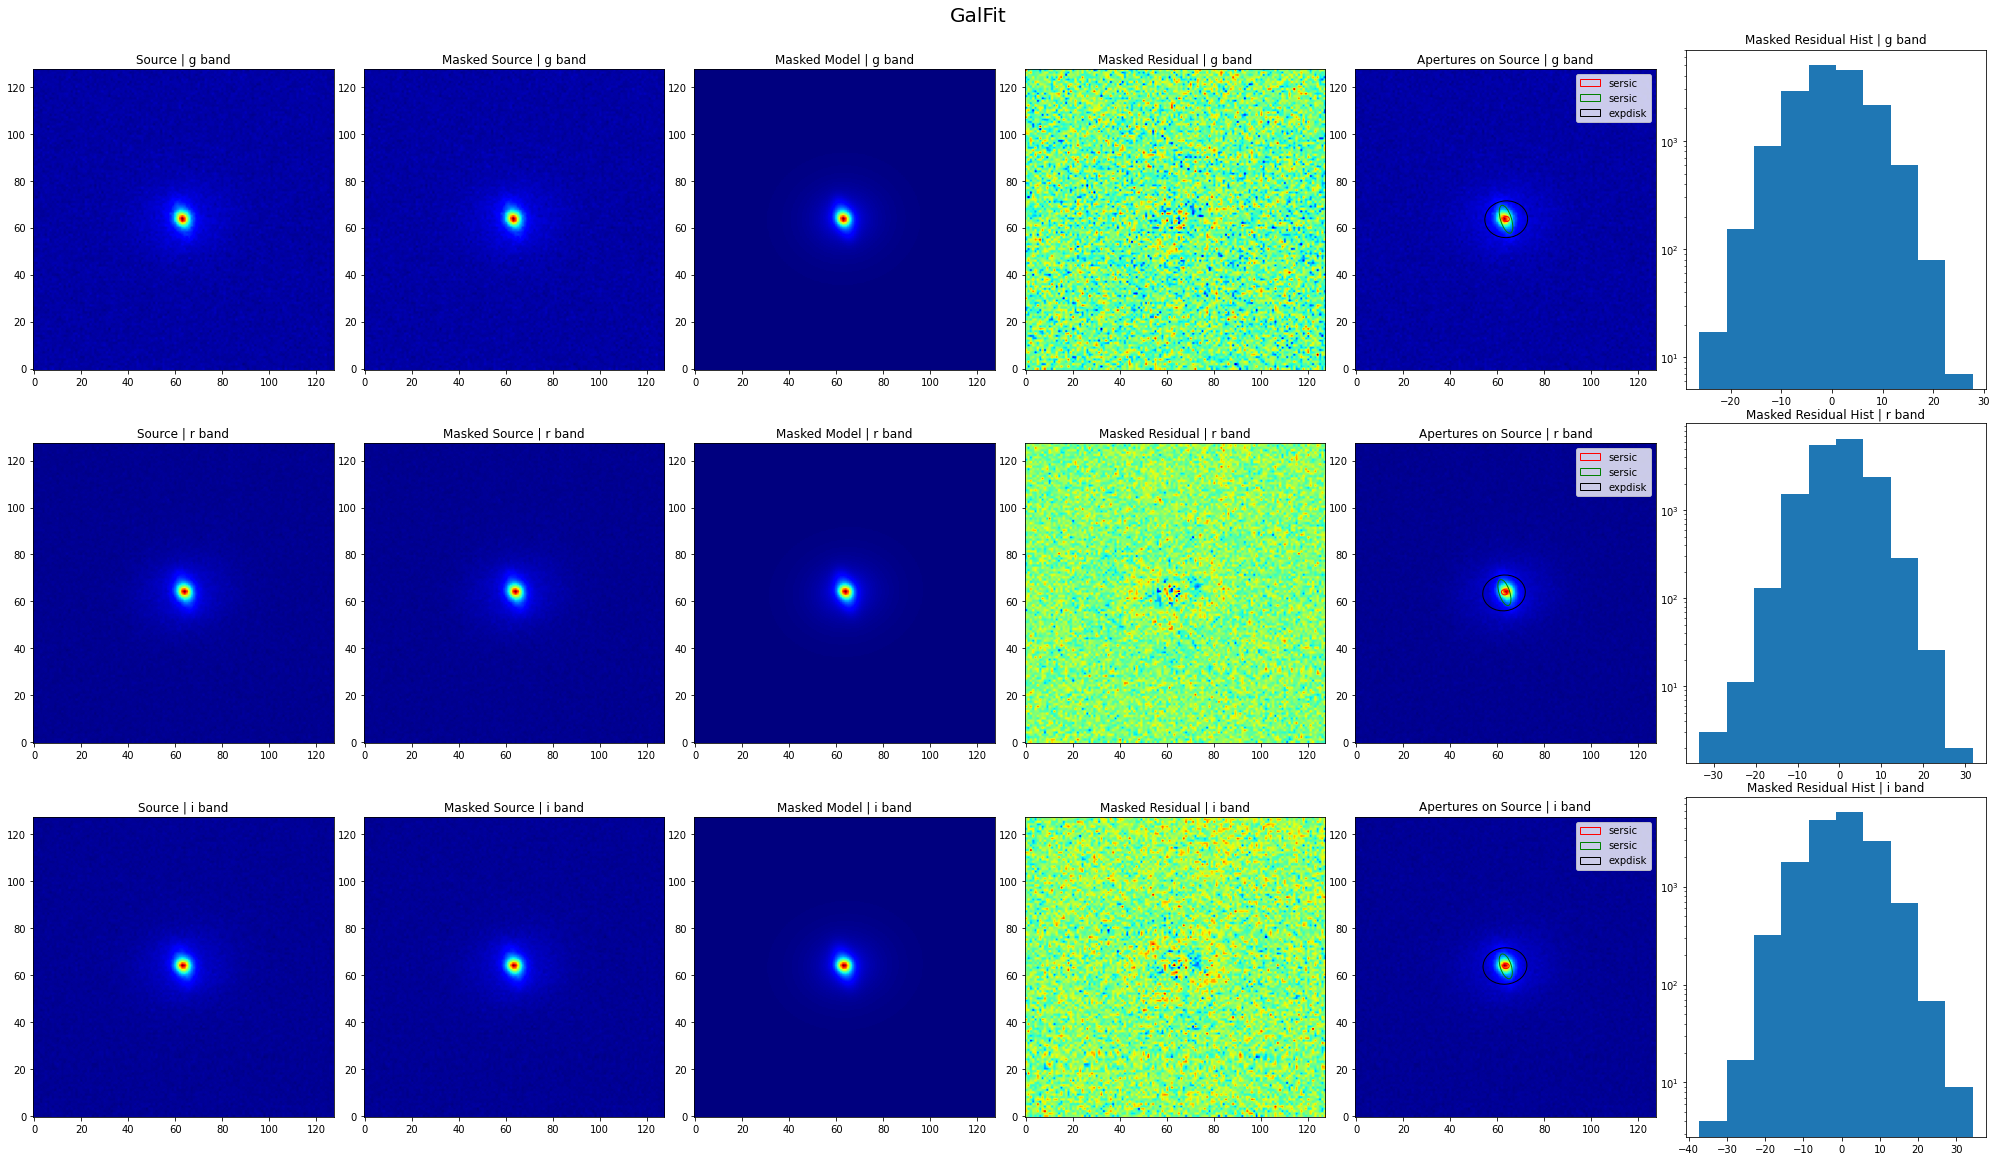

In [ ]:
show_image(oimgs, modss, bands)

In [ ]:
import json
with open('10215-3704.json', 'w') as fout:
    json.dump(modss, fout)

In [ ]:
with open('10215-3704.json', 'r') as fout:
  m = json.load(fout)

In [ ]:
m

[[{'1_AR': '0.8756 +/- 0.0306',
   '1_MAG': '18.3478 +/- 0.0654',
   '1_N': '1.4417 +/- 0.2527',
   '1_PA': '-23.5007 +/- 19.0349',
   '1_RE': '1.2344 +/- 0.0586',
   '1_XC': '64.7409 +/- 0.0162',
   '1_YC': '64.9281 +/- 0.0143',
   'COMP_1': 'sersic'},
  {'2_AR': '0.3745 +/- 0.0232',
   '2_MAG': '18.8291 +/- 0.0978',
   '2_N': '0.2791 +/- 0.0616',
   '2_PA': '-72.5808 +/- 0.9383',
   '2_RE': '6.1902 +/- 0.2675',
   '2_XC': '64.5830 +/- 0.1154',
   '2_YC': '64.7340 +/- 0.0478',
   'COMP_2': 'sersic'},
  {'3_AR': '0.8588 +/- 0.0084',
   '3_MAG': '17.0559 +/- 0.0072',
   '3_PA': '3.2814 +/- 3.1329',
   '3_RS': '9.1206 +/- 0.1409',
   '3_XC': '64.5974 +/- 0.1086',
   '3_YC': '64.8284 +/- 0.1106',
   'COMP_3': 'expdisk'},
  {'4_DSDX': '[0.000e+00]',
   '4_DSDY': '[0.000e+00]',
   '4_SKY': '1000.6627 +/- 0.0387',
   '4_XC': '[64.5000]',
   '4_YC': '[64.5000]',
   'COMP_4': 'sky'}],
 [{'1_AR': '0.8368 +/- 0.0213',
   '1_MAG': '17.6130 +/- 0.0552',
   '1_N': '1.1110 +/- 0.1395',
   '1_PA': '-

In [ ]:
hdu = fits.open('gal_i.fits')[0]

In [ ]:
plt.imshow(np.fliplr(hdu.data.T), cmap = 'jet', origin = 'lower')
plt.annotate('.',(60,60), (40,40), fontsize = 100)

In [ ]:
wcs = WCS(hdu.header)
data = hdu.data
data = data.byteswap().newbyteorder()
bkg = sep.Background(data,bh=64,bw=64,fh=3,fw=3)
bkg_image = bkg.back()
bkg_rms = bkg.rms()

sigma = 3.0 * 0.42466090014400953  # FWHM = 3.

kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

threshold = bkg.back() + (3.0 * bkg.rms())

segm = phot.detect_sources(data, threshold, npixels=5, kernel=kernel)
segm_deblend = deblend_sources(data, segm, npixels=5,
                              nlevels=32, contrast=0.001)
if len(segm_deblend.areas)>1:
  ind = np.where(segm_deblend.areas!=segm_deblend.areas.max())[0]+1
  segm_deblend.keep_labels(ind)
  mask = np.where(segm_deblend.data>0,1,0)
else:
  mask = data*0

In [ ]:
cmap = segm_deblend.make_cmap(seed = 123)
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')

In [ ]:
ra, dec = wcs.all_pix2world(0,0,1)

In [ ]:
ra

In [ ]:
!./content

/bin/bash: ./content: No such file or directory
